In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import re

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

# Load clusters

In [3]:
def parse_cdhit_clstr(clstr_path: str) -> pd.DataFrame:
    """
    Parses a CD-HIT .clstr file and returns a DataFrame with cluster and sequence IDs.

    Parameters:
    - clstr_path (str): Path to the .clstr file.

    Returns:
    - pd.DataFrame with columns: cluster_id, sequence_id
    """
    clusters = []
    current_cluster = -1

    with open(clstr_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>Cluster'):
                current_cluster += 1
            elif line:
                # Extract sequence ID from the line
                match = re.search(r'>?([\w|:.\-]+)\.\.\.', line)
                if match:
                    seq_id = int(match.group(1))
                    clusters.append((current_cluster, seq_id))
                else:
                    raise ValueError(f"Could not parse sequence ID from line: {line}")

    return pd.DataFrame(clusters, columns=["cluster_id", "sequence_id"])
clusters = parse_cdhit_clstr(".cache/cdhit/clusters.clstr")

# Split clusters into two sets

In [4]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['cluster_id'].unique()
    print(f"Found {len(cluster_ids)} clusters in the dataset.")
    # Clusters are ordered by size, so we can just take the last n_test clusters in order to maximize the diversity
    # Compute the cumsum of the cluster sizes
    cluster_sizes = clusters['cluster_id'].value_counts().sort_index()
    cum_sum = cluster_sizes.cumsum()
    n_train = int(len(clusters) * (1 - test_ratio))
    train_mask = cum_sum <= n_train
    train_clusters = cluster_sizes[train_mask].index.tolist()
    test_clusters = cluster_sizes[~train_mask].index.tolist()
    train_ids = clusters[clusters['cluster_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['cluster_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)

Found 679 clusters in the dataset.


# Assert independence between training and test sets

In [5]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")


 100%|██████████████████████████████████████|  2827/2827 [05:24<00:00, 8.89it/s] 


Max identity: 0.9705882352941176
Mean identity: 0.7034184089468114
Median identity: 0.7647058823529411
Quantiles:
- 0.01 quantile: 0.3333333333333333
- 0.05 quantile: 0.36363636363636365
- 0.10 quantile: 0.3888888888888889
- 0.25 quantile: 0.4807407407407407
- 0.50 quantile: 0.7647058823529411
- 0.75 quantile: 0.9090909090909091
- 0.90 quantile: 0.9444444444444444
- 0.95 quantile: 0.9523809523809523
- 0.99 quantile: 0.9615384615384616
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
4109


Text(0, 0.5, 'Frequency')

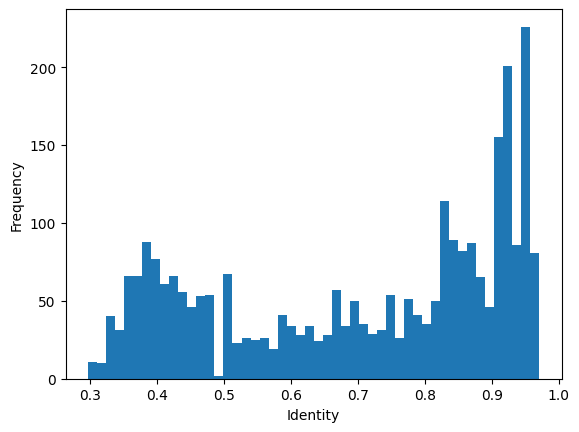

In [6]:
print(f"Max identity: {np.max(identities)}")
print(f"Mean identity: {np.mean(identities)}")
print(f"Median identity: {np.median(identities)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(identities, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(identities, bins=50)
plt.xlabel("Identity")
plt.ylabel("Frequency")